In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np
from sklearn.linear_model import LinearRegression
from pyomo.environ import * 
from pyomo.opt import SolverFactory

os.chdir("C:/Users/sinab/OneDrive/MMSc/MSCI 719/Assignment 5")

# Part 1

Tha dataset of JOANN includes demand data on weekly basis for years 2017 to 2019. The dataset is restructured for easier manipulation.

In [2]:
store_names =  ["Store1", "Store2", "Store3"]
df_stores = pd.read_excel("Case6-Data.xlsx", sheet_name=store_names)
df_stores = list(df_stores.values())
# Store ID are added to datasets
df_stores[0]["store"] = 1
df_stores[1]["store"] = 2
df_stores[2]["store"] = 3

## Part 1.1

The prediction function for demand is defined as:

demand of week n in 2019 = α(demand of week n in 2018 − Av. demand in 2018 up to week n − 1) +
(1 − α)(demand of week n in 2017 − Av. demand in 2017 up to week n − 1) +
Av. demand in 2019 up to week n − 1

In [3]:
# Calculating MSE for the first 5 weeks of 2019 using the prediction model
def MSE(prediction, actual):
    SE = 0
    n_obs = len(prediction)
    for i_obs in range(n_obs):
        SE += (prediction[i_obs] - actual[i_obs])**2
    return SE/n_obs

# Calculation of prediction of 2019 values for each store
# For the first week, a different prediciton formula is used: weighted average of corresponding values in the past years
def predict_model1(alpha, df, showfig=False):
    df.loc[0, "prediction1"] = df.loc[0, 2019]
    
    for weeki in range(1,10):
        df.loc[weeki, "prediction1"] = (alpha * (df.loc[weeki, 2018] - df.loc[0:weeki-1, 2018].mean()) +
                                        (1-alpha) * (df.loc[weeki, 2017] - df.loc[0:weeki-1, 2017].mean()) +
                                        df.loc[0:weeki-1, 2019].mean()
                                       )
    # Show comparison of the prediction and actual values    
    if showfig:
        fig, ax = plt.subplots()
        line, = ax.plot(df["week"], df.prediction1)
        line.set_label("Predicted demand of 2019")
        line, = ax.plot(df["week"], df[2018])
        line.set_label("Actual demand of 2019")
        ax.set_title("Prediction vs. actual demand in 2019 for the store at alpha={:.2f}".format(alpha))
        ax.tick_params(axis="x", rotation=45)
        ax.legend()

    df.rename(columns={"Unnamed: 0":"week"}, inplace=True)
    
    # Calculating MSE for the prediction of model 1
    nweeks = 5
    prediction1 = df.loc[0:4, "prediction1"]
    actual = df.loc[0:4, 2019]
    MSE_res = MSE(prediction1, actual)
    return MSE_res

In [4]:
# Calculating prediction values of model 1 for various values of alpha
for alphai in np.arange(0, 1.2, 0.1):
    print(20*"-")
    print("Alpha = {:.1f}".format(alphai))
    print(20*"-")
    for idx, df in enumerate(df_stores):
        MSE_res = predict_model1(df=df_stores[idx], alpha=alphai)
        print("{}: MSE = {:.0f}".format(store_names[idx], MSE_res))

--------------------
Alpha = 0.0
--------------------
Store1: MSE = 15554
Store2: MSE = 5243
Store3: MSE = 149
--------------------
Alpha = 0.1
--------------------
Store1: MSE = 12294
Store2: MSE = 5159
Store3: MSE = 159
--------------------
Alpha = 0.2
--------------------
Store1: MSE = 9518
Store2: MSE = 5221
Store3: MSE = 171
--------------------
Alpha = 0.3
--------------------
Store1: MSE = 7227
Store2: MSE = 5427
Store3: MSE = 186
--------------------
Alpha = 0.4
--------------------
Store1: MSE = 5419
Store2: MSE = 5778
Store3: MSE = 202
--------------------
Alpha = 0.5
--------------------
Store1: MSE = 4096
Store2: MSE = 6274
Store3: MSE = 220
--------------------
Alpha = 0.6
--------------------
Store1: MSE = 3257
Store2: MSE = 6915
Store3: MSE = 240
--------------------
Alpha = 0.7
--------------------
Store1: MSE = 2902
Store2: MSE = 7701
Store3: MSE = 262
--------------------
Alpha = 0.8
--------------------
Store1: MSE = 3032
Store2: MSE = 8632
Store3: MSE = 287
--------

Based on the values of $\alpha$ given above the optimal values of each store is:  
Store 1: $\alpha=0.7$, MSE=2902   
Store 2: $\alpha=0.1$, MSE=5159  
Store 3: $\alpha=0.0$, MSE=149

In [5]:
# for idx, df in enumerate(df_stores):
#     opt_res = opt.minimize_scalar(fun=predict_model1, args=(df))
#     print("For store {}, the optimal alpha is {:.2f} with the MSE of "
#           .format(idx+1, opt_res.x))

The comparison beween the predicted and actual demand is also povided in the figures below.

148.8625

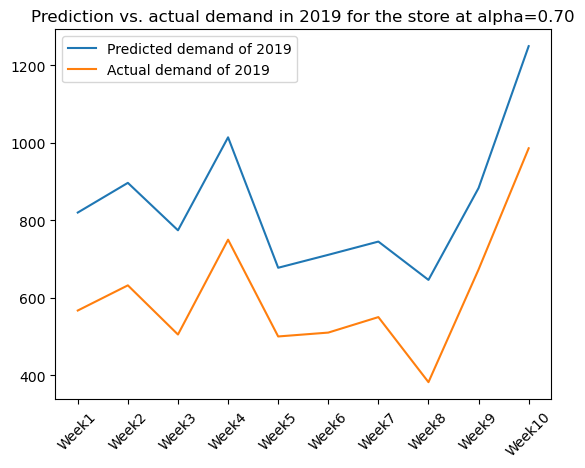

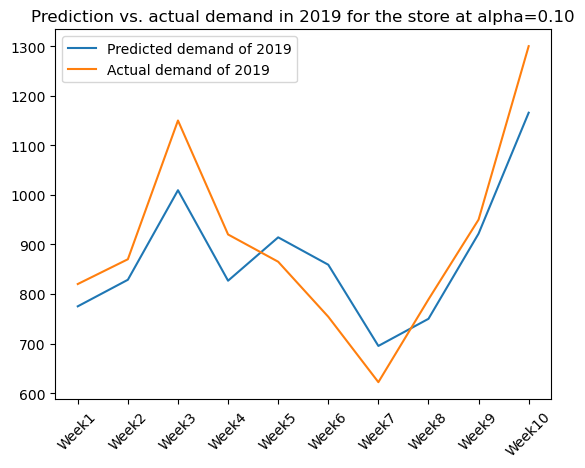

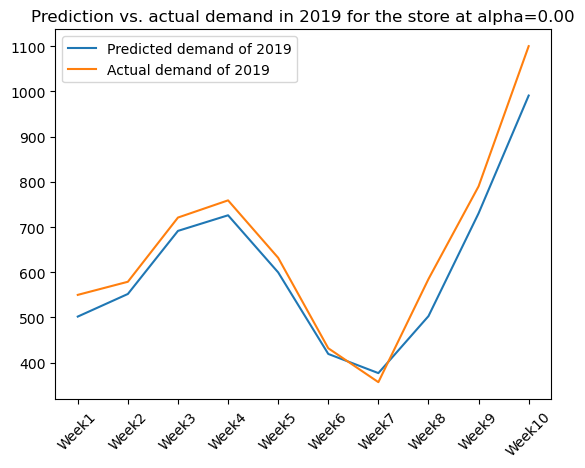

In [6]:
predict_model1(alpha=0.7, df=df_stores[0], showfig=True)
predict_model1(alpha=0.1, df=df_stores[1], showfig=True)
predict_model1(alpha=0, df=df_stores[2], showfig=True)

## Part 1.2

In [7]:
def predict_model2(df_store):
    # Making the dataset tidy
    
    df_long = df_store
    # Correcting week values
    df_long = (df_long.assign(week=lambda df_long: df_long.week.str[4:])
               .assign(week=lambda df_long: df_long.week.astype(int))
               .melt(id_vars=["week", "store"], value_vars=[2017, 2018, 2019],
                     var_name="year", value_name="demand")
               .sort_values(["store", "year", "week"])
              )
    all_predictors_vals = list()
    outcome_vals = list()
    for i in range(len(df_long)):
        outcome_vals.append(df_long.demand[i])
        obs_predictors_vals = list()
        # Create predictors for stratified weeks
        for week_predictor in range(1, 11):
            if df_long.loc[i, "week"]==week_predictor:
                obs_predictors_vals.append(1)
            else:
                obs_predictors_vals.append(0)
        obs_predictors_vals.append(i+1)
        all_predictors_vals.append(obs_predictors_vals) 
    
    # Creating sets of predictors and their outcome
    # Predictors include stratified weeks (binaries) and period length (integer)

    return (df_long, np.array(all_predictors_vals), np.array(outcome_vals))

for i in range(3):
    trainer_data = predict_model2(df_stores[i])
    x = trainer_data[1][0:20]
    y = trainer_data[2][0:20]
    model = LinearRegression().fit(x, y)
    model_res = model.score(x, y)

    x_test = trainer_data[1][20:25]
    actual = trainer_data[2][20:25]
    prediction = model.predict(x_test.reshape(5,-1))

    MSE_model2 = MSE(prediction, actual)
    print("Store {} | MSE = {:.0f}".format(i+1, MSE_model2))
# # Create prediction2 results
# for i in range(5):
#     cur_predictors
#     for week in range(1, 11):
#         if df_test.loc[i, "week"]==week:
#             cur_predictors.append(1)
#         else:
#             cur_predictors.append(0)

Store 1 | MSE = 97075
Store 2 | MSE = 24598
Store 3 | MSE = 4788


## Part 1.3

In [8]:
for idx, df in enumerate(df_stores):
    df.loc[:, "prediction3"] = df.loc[:, 2018]
    prediction = df.loc[0:4,"prediction3"]
    actual = df.loc[0:4, 2019]
    MSE_model3 = MSE(prediction, actual)
    print("Store {} | MSE = {:.0f}".format(idx+1, MSE_model3))

Store 1 | MSE = 71689
Store 2 | MSE = 14647
Store 3 | MSE = 1486


Among all the models provided above, model 1 has the lowest MSE so it is selected for the rest of this study.

## Part 2

* The holding and shortage costs are 3 and 5 per unit, respectively.
* Each item that remains in the distribution center at the end of week 10, incurs 2 dollar cost.
* Target inventory at the beginning of week 1 (available inventory at the distribution center) is 20000.
* The inventory allocated to each store at the beginning of each week should be between 150 and 1000.
* Available inventory at the beginning of week 1, at stores 1, 2, and 3 are 55, 83, and 110, respectively

In [9]:
# Assumptions
inv = [0] * 30
inv[0] = 55
inv[10] = 83
inv[20] = 110
holding_rate = 3
shortage_rate = 5
center_extra_rate = 2
Target_inv = 20000

## Part 2.1: Scenario 1
At the beginning of week 1 in 2019, an allocation plan is created for the whole 10 weeks, and at the
beginning of each week (week 1-10) inventory is allocated to stores based on the plan, independent of
overstocking/understocking during each week.

In [10]:
# Linear programming solver setup
solverpath_exe = "D:\\anaconda3\\pkgs\\glpk-5.0-h8ffe710_0\\Library\\bin\glpsol.exe"
solvername="glpk"
solver = SolverFactory(solvername,executable=solverpath_exe)

# Define the index set for the array
N = list(range(30))

prediction = list()
for i in range(3):
    prediction.extend(df_stores[i].loc[0:10, "prediction1"])

actual = list()
for i in range(3):
    actual.extend(df_stores[i].loc[0:10, 2019])

model = ConcreteModel(name="JOANN")
    
# Define the decision variables as an array
model.x = Var(N, within=NonNegativeReals, bounds=(150, 1000))

# Define the objective function
model.obj = Objective(expr=sum(model.x[i] for i in N), sense=maximize)

# Define the constraints
model.constraints = ConstraintList()

for i in range(10):
    model.constraints.add(model.x[i] + inv[i] <= prediction[i])
    model.constraints.add(model.x[i+10] + inv[i+10] <= prediction[i+10])
    model.constraints.add(model.x[i+20] + inv[i+20] <= prediction[i+20])
model.constraints.add(sum(model.x[i] for i in N) <= Target_inv)

# Solve and report solution
sol = solver.solve(model)
scen1_df = pd.DataFrame()
print("Optimal allocation values are:")
for i in range(30):
    scen1_df.at[i,"Week Number"] = (i + 1)%10
    scen1_df.at[i,"actual"] = actual[i]
    scen1_df.at[i, "Optimal Allocation"] = model.x[i].value
    scen1_df.at[i, "Inventory"] = inv[i]
    scen1_df.at[i, "Stockout"] = max(actual[i] - model.x[i].value - inv[i], 0)
    scen1_df.at[i, "Unsold"] = max(-actual[i] + model.x[i].value + inv[i], 0)
    scen1_df.at[i, "Store"] = 1+i//10
print(scen1_df)
shortage_cost = sum([scen1_df.at[i, "Stockout"] for i in range(30)])*shortage_rate
holding_cost = sum([scen1_df.at[i, "Unsold"] for i in range(30)])*holding_rate
remaining_cost = (Target_inv - sum(model.x[:].value))*center_extra_rate
total_cost = shortage_cost + holding_cost + remaining_cost

print(70*"-")
print("Sum of the allocations: {0:15.0f}".format(sum(model.x[:].value)))
print("Remaining allocations cost: {0:11.0f}".format(remaining_cost))
print("Total shortage cost: {0:18.0f}".format(shortage_cost))
print("Total holding cost: {0:19.0f}".format(holding_cost))
print("Total cost: {0:27.0f}".format(total_cost))

Optimal allocation values are:
    Week Number  actual  Optimal Allocation  Inventory    Stockout  \
0           1.0   820.0          765.000000       55.0    0.000000   
1           2.0   995.0          896.700000        0.0   98.300000   
2           3.0   720.0          774.150000        0.0    0.000000   
3           4.0  1010.0         1000.000000        0.0   10.000000   
4           5.0   721.0          495.230317        0.0  225.769683   
5           6.0   712.0          150.000000        0.0  562.000000   
6           7.0   760.0          150.000000        0.0  610.000000   
7           8.0   622.0          150.000000        0.0  472.000000   
8           9.0   810.0          150.000000        0.0  660.000000   
9           0.0  1376.0         1000.000000        0.0  376.000000   
10          1.0   775.0          692.000000       83.0    0.000000   
11          2.0   801.0          828.600000        0.0    0.000000   
12          3.0   895.0         1000.000000        0.0    0

#  Part 2.1: Scenario 2
At the beginning of each week, the allocation plan is updated by considering the available inventory at
each store. Assume that the allocation to each store should not exceed the demand minus the available
inventory at the store at the beginning of the week.


In [11]:
# Linear programming solver setup
solverpath_exe = "D:\\anaconda3\\pkgs\\glpk-5.0-h8ffe710_0\\Library\\bin\glpsol.exe"
solvername="glpk"
solver = SolverFactory(solvername,executable=solverpath_exe)

prediction = list()
for i in range(3):
    prediction.extend(df_stores[i].loc[0:10, "prediction1"])

actual = list()
for i in range(3):
    actual.extend(df_stores[i].loc[0:10, 2019])

scen2_df = pd.DataFrame()
used_inv = 0
for iweek in range(10):
    # Define the index set for the array
    N = list(range(30-3*iweek))
        
    model = ConcreteModel(name="JOANN")

    # Define the decision variables as an array
    model.x = Var(N, within=NonNegativeReals, bounds=(150, 1000))

    # Define the inventories as an array
    model.inv = Var(N, within=NonNegativeReals, bounds=(150, 1000))

    # Define the objective function
    model.obj = Objective(expr=sum(model.x[i] for i in N), sense=maximize)

    # Define the constraints
    model.constraints = ConstraintList()

    for i in range(10-iweek):
        model.constraints.add(model.x[i] + inv[i] <= prediction[i])
        model.constraints.add(model.x[i+10-iweek] + inv[i+10-iweek] <= prediction[i+10-iweek])
        model.constraints.add(model.x[i+20-2*iweek] + inv[i+20-2*iweek] <= prediction[i+20-2*iweek])
    model.constraints.add(sum(model.x[i] for i in N) <= Target_inv - used_inv)
    
    if iweek > 0:
        inv[iweek] = max(-actual[iweek-1] + inv[iweek-1] + scen2_df.at[iweek-1, "Optimal Allocation"], 0)
        inv[10+iweek] = max(-actual[10+iweek-1] + inv[10+iweek-1] + scen2_df.at[10+iweek-1, "Optimal Allocation"], 0)
        inv[20+iweek] = max(-actual[20+iweek-1] + inv[20+iweek-1] + scen2_df.at[20+iweek-1, "Optimal Allocation"], 0)

    # Solve and report solution
    sol = solver.solve(model)
    scen2_df.at[iweek, "Optimal Allocation"] = model.x[0].value
    scen2_df.at[10+iweek, "Optimal Allocation"] = model.x[10-iweek].value
    scen2_df.at[20+iweek, "Optimal Allocation"] = model.x[20-2*iweek].value
    # Obtain sum of used allocations (for substraction from the target allocation)
    used_inv +=  model.x[0].value + model.x[10-iweek].value + model.x[20-2*iweek].value
                          
    
print("Optimal allocation values are:")
for i in range(30):
    scen2_df.at[i,"Week Number"] = (i + 1)%10
    scen2_df.at[i,"actual"] = actual[i]
    scen2_df.at[i, "Inventory"] = inv[i]
    scen2_df.at[i, "Stockout"] = max(actual[i] - scen2_df.at[i, "Optimal Allocation"] - inv[i], 0)
    scen2_df.at[i, "Unsold"] = max(-actual[i] + scen2_df.at[i, "Optimal Allocation"] + inv[i], 0)
    scen2_df.at[i, "Store"] = 1+i//10
    scen2_df = scen2_df.sort_index(axis=0)
print(scen2_df)
shortage_cost = sum([scen2_df.at[i, "Stockout"] for i in range(30)])*shortage_rate
holding_cost = sum([scen2_df.at[i, "Unsold"] for i in range(30)])*holding_rate
remaining_cost = (Target_inv - sum(scen2_df.at[i, "Optimal Allocation"] for i in range(30)))*center_extra_rate
total_cost = shortage_cost + holding_cost + remaining_cost

print(70*"-")
print("Sum of the allocations: {0:10.0f}".format(sum(scen2_df.at[i, "Optimal Allocation"] for i in range(30))))
print("Remaining allocations cost: {0:5.0f}".format(remaining_cost))
print("Total shortage cost: {0:13.0f}".format(shortage_cost))
print("Total holding cost: {0:14.0f}".format(holding_cost))
print("Total cost: {0:22.0f}".format(total_cost))

Optimal allocation values are:
    Optimal Allocation  Week Number  actual    Inventory    Stockout  \
0           765.000000          1.0   820.0    55.000000    0.000000   
1           765.000000          2.0   995.0     0.000000  230.000000   
2           765.000000          3.0   720.0     0.000000    0.000000   
3           765.000000          4.0  1010.0    45.000000  200.000000   
4           765.000000          5.0   721.0     0.000000    0.000000   
5           765.000000          6.0   712.0    44.000000    0.000000   
6           765.000000          7.0   760.0    97.000000    0.000000   
7           765.000000          8.0   622.0   102.000000    0.000000   
8           765.000000          9.0   810.0   245.000000    0.000000   
9           765.000000          0.0  1376.0   200.000000  411.000000   
10          692.000000          1.0   775.0    83.000000    0.000000   
11         1000.000000          2.0   801.0     0.000000    0.000000   
12          150.000000          3

##  Part 2.2
The second scenario shows higher amount of total cost. This is against the expected outcome because the second scenario can correct errors by updating the allocations. The reason behind this unexpected result can be a mistake in the code, which required further review for any possible error. However, it should be mentioned that the two scenarios are not optimizing for minimum costs so we cannot say dynamic behavior of the second scenario is taking into account the difference in the costs of holding and shortage.